# Notes for this revision

- Attempt to eliminate pitch acceleration predictions and just predict coefficients
- Initialize weights manually for hyper parameter optimization

In [1]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, BatchNormalization, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from scipy.signal import butter, filtfilt
import os
from tensorflow.keras import backend as K
from control import matlab as MATLAB


K.clear_session()

os.chdir('/home/coder/workspace/VanderWiel/Fennec2023/SystemID')
name = 'simulated_outputs.csv'

data = pd.read_csv(name)
    
print(data.shape)

(500000, 5)


In [2]:
# resetting RAM in gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [3]:
def lowpass(order, highStop, sampleRate, data):
    '''
    The function uses a Butterworth low pass filter and returns the filtered time-series data

    :param order: order of the filter (higher order means faster roll off), int
    :param highStop: high frequency before the roll off starts, int
    :param sampleRate: sample rate at which the data was collected, int
    :param data: collected data, array_like
    '''
    b, a = butter(order, highStop, 'lowpass', fs=sampleRate)
    return filtfilt(b, a, data)


In [4]:
t = data.iloc[1:, 0].values
Vp = data.iloc[1:, 1].values
Vy = data.iloc[1:, 2].values
pitch = data.iloc[1:, 3].values
yaw = data.iloc[1:, 4].values

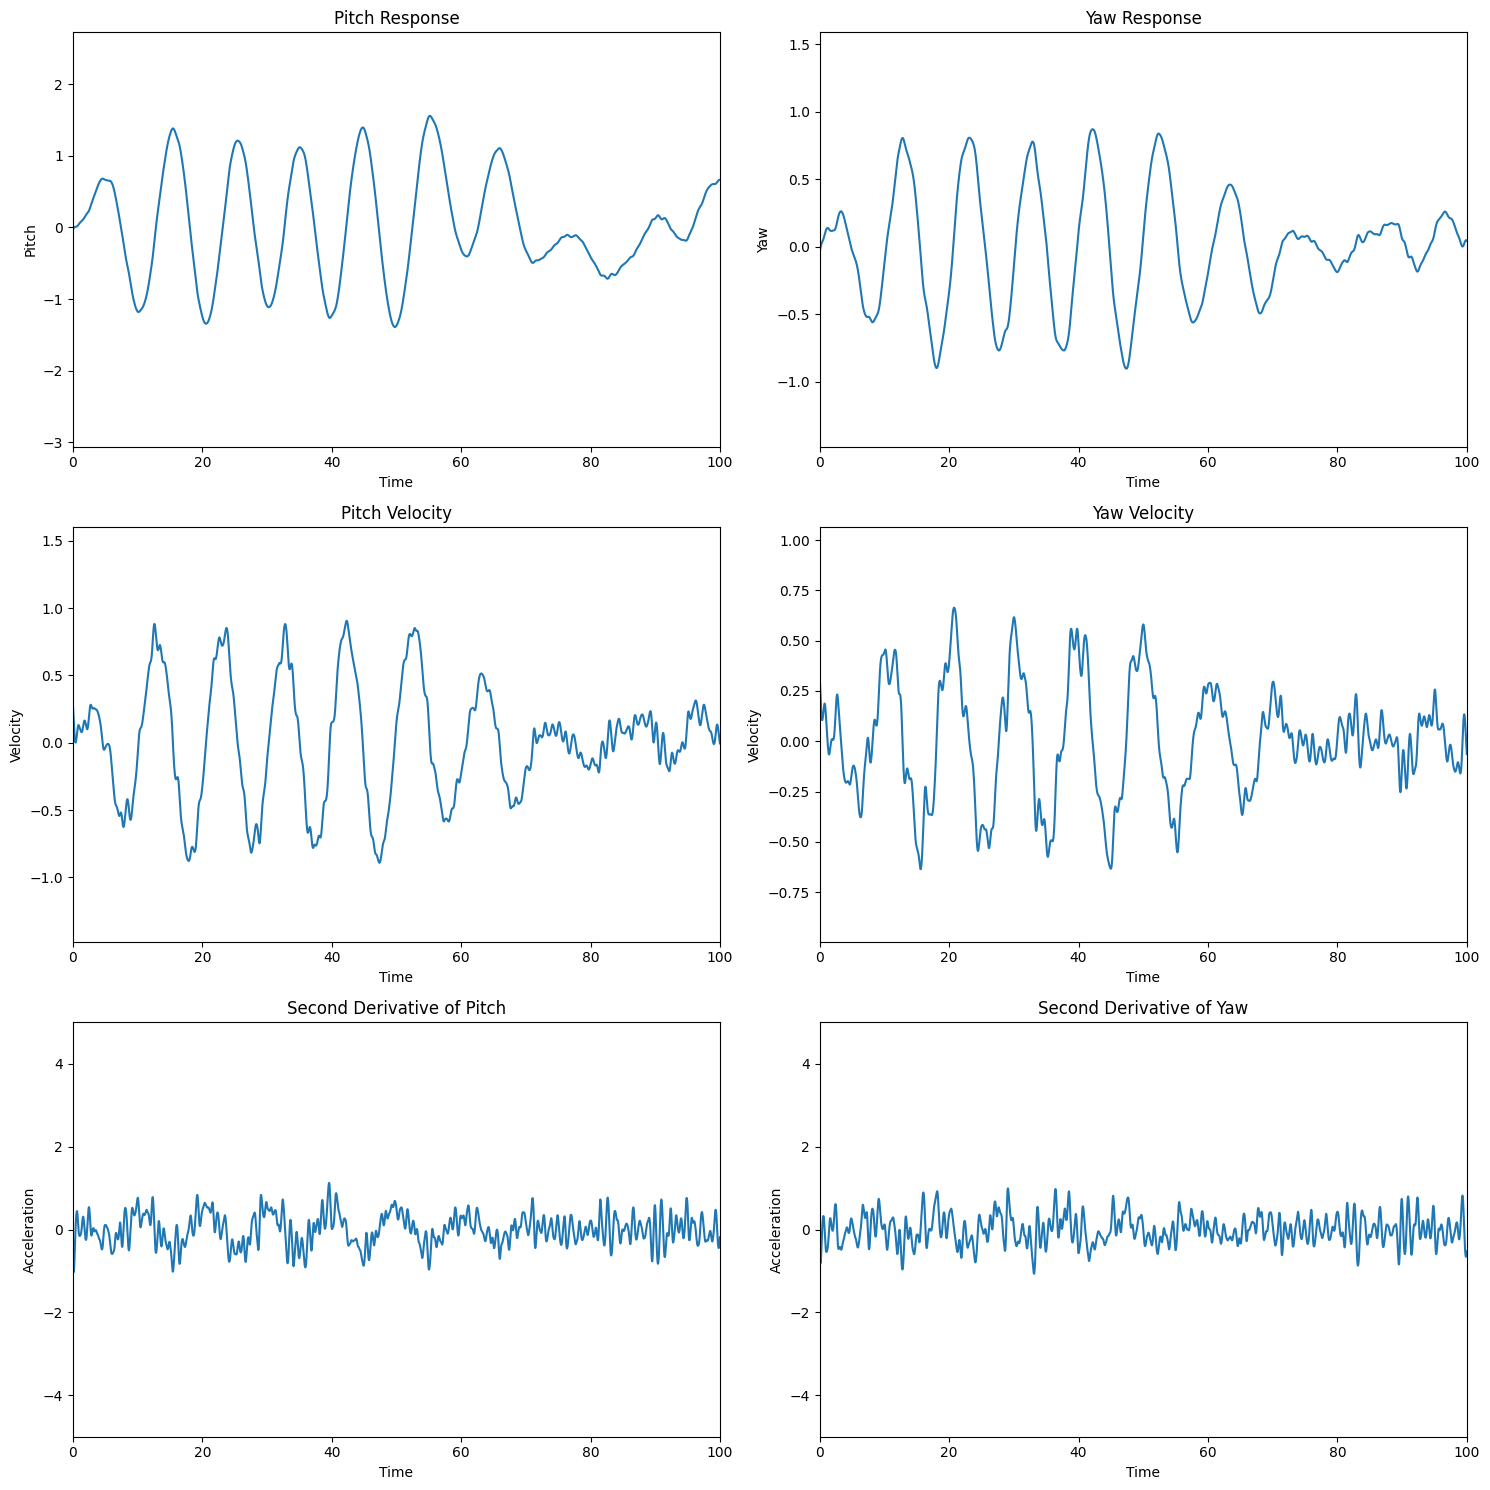

In [5]:
# Filter noise
order = 3
highStop = 1
sampleRate = len(data)/t[-1]

pitch = lowpass(order, highStop, sampleRate, pitch)
yaw = lowpass(order, highStop, sampleRate, yaw)

# Compute velocity derivatives
tstep = t[2]-t[1]
pitch_velocity = np.array([np.diff(pitch, n=1)])
pitch_velocity = np.transpose(pitch_velocity)/tstep
pitch_velocity= np.append(pitch_velocity, 0)
yaw_velocity = np.array([np.diff(yaw, n=1)])
yaw_velocity = np.transpose(yaw_velocity)/tstep
yaw_velocity = np.append(yaw_velocity, 0)

# Compute acceleration derivatives
# We are computing accelerations becuase we don't trust the measured values are labeled correctly
d2pitchdt2 = np.array([np.diff(pitch_velocity, n=1)])
d2pitchdt2 = np.transpose(d2pitchdt2)/tstep
d2pitchdt2= np.append(d2pitchdt2, 0)
d2yawdt2 = np.array([np.diff(yaw_velocity, n=1)])
d2yawdt2 = np.transpose(d2yawdt2)/tstep
d2yawdt2 = np.append(d2yawdt2, 0)

# plotting as a data check
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # Adjust figsize as needed

# Set common x-axis limits for all subplots
for row in axs:
    for ax in row:
        ax.set_xlim([0, 100])

# Plot pitch response in the first subplot
axs[0, 0].plot(t, pitch)
axs[0, 0].set_title('Pitch Response')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Pitch')

# Plot pitch velocity in the second subplot
axs[1, 0].plot(t, pitch_velocity)
axs[1, 0].set_title('Pitch Velocity')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Velocity')

# Plot second derivative of pitch in the third subplot
axs[2, 0].plot(t, d2pitchdt2)
axs[2, 0].set_title('Second Derivative of Pitch')
axs[2, 0].set_xlabel('Time')
axs[2, 0].set_ylabel('Acceleration')
axs[2, 0].set_ylim([-5,5])

# Plot yaw response in the fourth subplot
axs[0, 1].plot(t, yaw)
axs[0, 1].set_title('Yaw Response')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Yaw')

# Plot yaw velocity in the fifth subplot
axs[1, 1].plot(t, yaw_velocity)
axs[1, 1].set_title('Yaw Velocity')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Velocity')

# Plot second derivative of yaw in the sixth subplot
axs[2, 1].plot(t, d2yawdt2)
axs[2, 1].set_title('Second Derivative of Yaw')
axs[2, 1].set_xlabel('Time')
axs[2, 1].set_ylabel('Acceleration')
axs[2, 1].set_ylim([-5,5])

# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()


In [6]:
inputs = np.array([t, Vp, Vy, pitch, yaw, pitch_velocity, yaw_velocity, d2yawdt2]) # Everything in the order previously defined
inputs = np.transpose(inputs)

outputs = np.array([d2pitchdt2])
outputs = np.transpose(outputs)

print("Shape of inputs array:", inputs.shape)
print('Shape of outputs array:', outputs.shape)

# input_train, input_test, output_train, output_test = train_test_split(inputs, outputs, shuffle=False, test_size=0.25)
input_train, input_test, output_train, output_test = train_test_split(inputs, outputs, test_size=0.25, random_state=42, shuffle=False)

tf.random.set_seed(42)

model = Sequential([
    Dense(units=200, activation='tanh'),
    Dense(units=50, activation='tanh'),
    Dense(units=50, activation='tanh'),
    Dense(units=4, activation='linear') # Outputs 4 predicted coefficients
])

optm = tf.keras.optimizers.Adam(learning_rate = 0.036)

Shape of inputs array: (499999, 8)
Shape of outputs array: (499999, 1)


In [7]:
def custom_loss(input_train, output_train, net, itr):
    # Convert inputs and outputs to tensors
    input_train = tf.convert_to_tensor(input_train, dtype=tf.float32)
    output_train = tf.convert_to_tensor(output_train, dtype=tf.float32)

    # Assign an array for the current set of network predictions
    # These are the coefficients that are going to be used in calculating eq. loss
    # and acceleration for collocation loss
    predictions = net(input_train)

   # unpack coefficients
    pred_coeff1 = net(input_train)[:,0]
    pred_coeff2 = net(input_train)[:,1]
    pred_coeff3 = net(input_train)[:,2]
    pred_coeff4 = net(input_train)[:,3]

    # calculate 1st and 2nd numerical derivatives of the coeffiecients
    grad1 = tf.experimental.numpy.diff(pred_coeff1)
    dgrad1 = tf.experimental.numpy.diff(grad1)
    grad2 = tf.experimental.numpy.diff(pred_coeff2)
    dgrad2 = tf.experimental.numpy.diff(grad2)
    grad3 = tf.experimental.numpy.diff(pred_coeff3)
    dgrad3 = tf.experimental.numpy.diff(grad3)
    grad4 = tf.experimental.numpy.diff(pred_coeff4)
    dgrad4 = tf.experimental.numpy.diff(grad4)

    # reshape coeffiecients and their derivatives
    pred_coeff1 = tf.expand_dims(pred_coeff1, axis=1)
    pred_coeff2 = tf.expand_dims(pred_coeff2, axis=1)
    pred_coeff3 = tf.expand_dims(pred_coeff3, axis=1)
    pred_coeff4 = tf.expand_dims(pred_coeff4, axis=1)
    grad1 = tf.expand_dims(grad1, axis=1)
    dgrad1 = tf.expand_dims(dgrad1, axis=1)
    grad2 = tf.expand_dims(grad2, axis=1)
    dgrad2 = tf.expand_dims(dgrad2, axis=1)
    grad3 = tf.expand_dims(grad3, axis=1)
    dgrad3 = tf.expand_dims(dgrad3, axis=1)
    grad4 = tf.expand_dims(grad4, axis=1)
    dgrad4 = tf.expand_dims(dgrad4, axis=1)

    # Getting variables ready for equation loss
    theta = input_train[:,3] # theta = yaw_response
    theta = tf.expand_dims(theta, axis=1)
    dtheta = input_train[:,5] # dtheta = yaw_velocity
    dtheta = tf.expand_dims(dtheta, axis=1)
    Vp = input_train[:,1] # 
    Vp = tf.expand_dims(Vp, axis=1) 
    Vy = input_train[:,2]
    Vy = tf.expand_dims(Vy, axis=1)
    
    # Compute L_eq: Equation Loss
    # This is based on the state space model of the Quanser
    L_eq = tf.reduce_mean(tf.square(pred_coeff1*theta+pred_coeff2*dtheta+pred_coeff3*Vp+pred_coeff4*Vy-output_train)) # Voltage is in Volts

    # Gradient loss: trying to force the coefficients to be constant
    L_gr1 = tf.reduce_mean(tf.square(grad1 - 0)) #+ tf.reduce_mean(tf.square(dgrad1 - 0))
    L_gr2 = tf.reduce_mean(tf.square(grad2 - 0)) #+ tf.reduce_mean(tf.square(dgrad2 - 0))
    L_gr3 = tf.reduce_mean(tf.square(grad3 - 0)) #+ tf.reduce_mean(tf.square(dgrad3 - 0))
    L_gr4 = tf.reduce_mean(tf.square(grad4 - 0)) #+ tf.reduce_mean(tf.square(dgrad4 - 0))

    L_gr = L_gr1 + L_gr2 + L_gr3 + L_gr4

    # Adjusting loss component weights trying to make them roughly equal
    # Automatically adjust the weights after the first run
    # if itr == 0:
    #     global L_eq_norm, L_gr_norm, L_c_norm
    #     L_eq_norm = L_eq
    #     L_gr_norm = L_gr

    # L_eq = L_eq/L_eq_norm
    # L_gr = L_gr/L_gr_norm

    L_total = L_eq + L_gr

    return L_total

In [8]:
def nrmse(actual_values, predicted_values):
    """
    Calculate Normalized Root Mean Squared Error (NRMSE) for regression. Normalized over the range of the target variable
    In this case it's the range of the pitch acceleration data

    Parameters:
    - actual_values: NumPy array or list of actual values.
    - predicted_values: NumPy array or list of predicted values.

    Returns:
    - nrmse: Normalized Root Mean Squared Error.
    """
    actual_values = np.array(actual_values).flatten()
    predicted_values = np.array(predicted_values).flatten()

    if len(actual_values) != len(predicted_values):
        raise ValueError("Length of actual_values and predicted_values must be the same.")

    # Calculate RMSE
    rmse = np.sqrt(np.mean((actual_values - predicted_values) ** 2))

    # Calculate the range of the target variable
    target_range = np.max(actual_values) - np.min(actual_values)

    # Calculate NRMSE
    nrmse = (rmse / target_range) * 100 # Expressed as a percentage

    return nrmse


I0000 00:00:1708903869.163598   10142 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0 :  102.95929
100 :  0.058854997
200 :  0.05148911
300 :  0.051450863
400 :  0.051449414
500 :  0.051448304
600 :  0.0514473
700 :  0.05144621
800 :  0.051444978
900 :  0.051443927


Text(0.5, 1.0, 'Training loss per epoch')

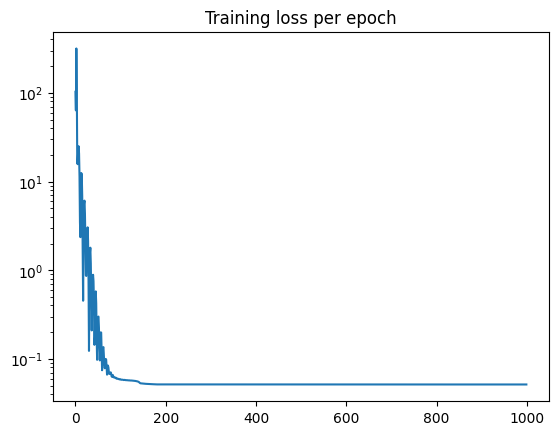

In [9]:
# Training loop

train_loss_record = []
# 4000
for itr in range(1000):
    with tf.GradientTape() as tape:
        train_loss = custom_loss(input_train, output_train, model, itr)
        train_loss_record.append(train_loss)
        grad_w = tape.gradient(train_loss, model.trainable_variables)
        optm.apply_gradients(zip(grad_w, model.trainable_variables))

    if itr % 100 == 0:
        print(itr, ': ', train_loss.numpy())

plt.semilogy(train_loss_record)
# plt.plot(train_loss_record)
plt.title('Training loss per epoch')


In [13]:
# Making Predictions
pitch_predictions_fnn = model.predict(input_test)

coeff1 = np.mean(pitch_predictions_fnn[:,0])
coeff2 = np.mean(pitch_predictions_fnn[:,1])
coeff3 = np.mean(pitch_predictions_fnn[:,2])
coeff4 = np.mean(pitch_predictions_fnn[:,3])



3907/3907 [==============================] - 5s 1ms/step


In [15]:
print(coeff1, -0.321)
print(coeff2, -0.086)
print(coeff3, 0.023)
print(coeff4, 0.0099)

-0.32986468 -0.321
-0.09131111 -0.086
0.023115883 0.023
0.009924353 0.0099


In [16]:
from control import matlab as MATLAB

# AERO-2 MIMO system

# Moment of inertia about pitch-axis (kg-m^2)
Jp = 0.0232  # from CAD: 23188500.45 g-mm^2

# Moment of inertia about pitch-axis (kg-m^2)
Jy = 0.0238  # from CAD: 23810415.95 g-mm^2;

Dt = 0.16743  # distance from pivot to center of rotor/propeller (m)

# Experiment Pitch Parameters
Ksp = 0.00744  # Stiffness (N-m/(rad))
Dp = 0.00199  # Damping (N-m/(rad/s))
Kpp = 0.00321  # Pitch thrust gain (N/V)
Kpy = 0.00137  # Pitch from yaw thrust gain (N/V)

# Experimental Yaw Parameters
Dy = 0.00192  # Damping (N-m/(rad/s))
Kyy = 0.00610  # Yaw thrust gain Thrust (N/V)
Kyp = -0.00319  #  Yaw from pitch thrust gain (N/V)


# Set up state-space system
A = [[0, 0, 1, 0],
     [0, 0, 0, 1],
     [-Ksp/Jp, 0, -Dp/Jp, 0],
     [0, 0, 0, -Dy/Jy]]

A_est = [[0, 0, 1, 0],
     [0, 0, 0, 1],
     [coeff1, 0, coeff2, 0],
     [0, 0, 0, -Dy/Jy]]

B = [[0, 0],
     [0, 0],
     [Kpp*Dt/Jp, Kpy*Dt/Jp],
     [Kyp*Dt/Jy, Kyy*Dt/Jy]]

B_est = [[0, 0],
     [0, 0],
     [coeff3, coeff4],
     [Kyp*Dt/Jy, Kyy*Dt/Jy]]

C = [[1, 0, 0, 0],
     [0, 0, 1, 0]]

D = [[0, 0],
     [0, 0]]

AERO1 = MATLAB.ss(A, B, C, D)
AERO2 = MATLAB.ss(A_est,B_est,C,D)

print(AERO1)
# print(AERO2)

<LinearIOSystem>: sys[2]
Inputs (2): ['u[0]', 'u[1]']
Outputs (2): ['y[0]', 'y[1]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[ 0.          0.          1.          0.        ]
     [ 0.          0.          0.          1.        ]
     [-0.32068966  0.         -0.08577586  0.        ]
     [ 0.          0.          0.         -0.08067227]]

B = [[ 0.          0.        ]
     [ 0.          0.        ]
     [ 0.02316596  0.00988703]
     [-0.02244125  0.04291273]]

C = [[1. 0. 0. 0.]
     [0. 0. 1. 0.]]

D = [[0. 0.]
     [0. 0.]]



In [32]:
error1 = np.abs(((-Ksp/Jp) - coeff1)/(-Ksp/Jp))*100
error2 = np.abs(((-Dp/Jp) - coeff2)/(-Dp/Jp))*100
error3 = np.abs(((Kpp*Dt/Jp) - coeff3)/(Kpp*Dt/Jp))*100
error4 = np.abs(((Kpy*Dt/Jp) - coeff4)/(Kpy*Dt/Jp))*100

print(error1, error2, error3, error4)


2.861029486502361 6.453155752402448 0.2161730153631784 0.37749382063972037


Pitch NRMSE: 0.9082045416250323 %
Yaw NRMSE: 0.7830896371055422 %


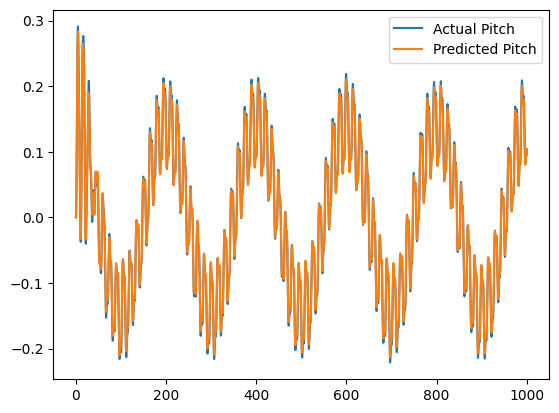

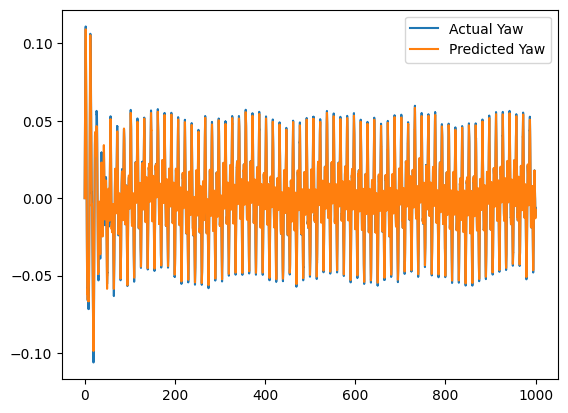

In [17]:
shape = (100000,)
time = np.linspace(0, 1000, shape[0])

amp = 1 # Volts
fn = 0.2 # Hz
noise_stddev = 0.25 # Standard Deviation of the Gaussian Noise

# Generate sine wave
Vp = amp * np.sin(2 * np.pi * fn * time) + 2 * np.cos(2 * np.pi * 0.005 * time) + 0.4 * np.cos(2 * np.pi * 1 * time)

# plt.plot(Vp)

# Add random Gaussian noise
noise = np.random.normal(loc=0, scale=noise_stddev, size=len(time))
Vp = Vp + noise


Vy = amp * np.cos(2 * np.pi * fn/3 * time) - np.sin(5*time)
Vy = Vy + noise

U = np.array([Vp,Vy])
U = np.transpose(U)

yout1, T1, xout1 = MATLAB.lsim(AERO1, U, time, 0)
yout2, T2, xout2 = MATLAB.lsim(AERO2, U, time, 0)


plt.plot(T1,yout1[:,0])
plt.plot(T2,yout2[:,0])
plt.legend(['Actual Pitch','Predicted Pitch'],loc='best')
# plt.xlim([0,100])

plt.figure()
plt.plot(T1,yout1[:,1])
plt.plot(T2,yout2[:,1])
plt.legend(['Actual Yaw','Predicted Yaw'],loc='best')

print('Pitch NRMSE:', nrmse(yout1[:,0],yout2[:,0]), '%')
print('Yaw NRMSE:', nrmse(yout1[:,1],yout2[:,1]), '%')


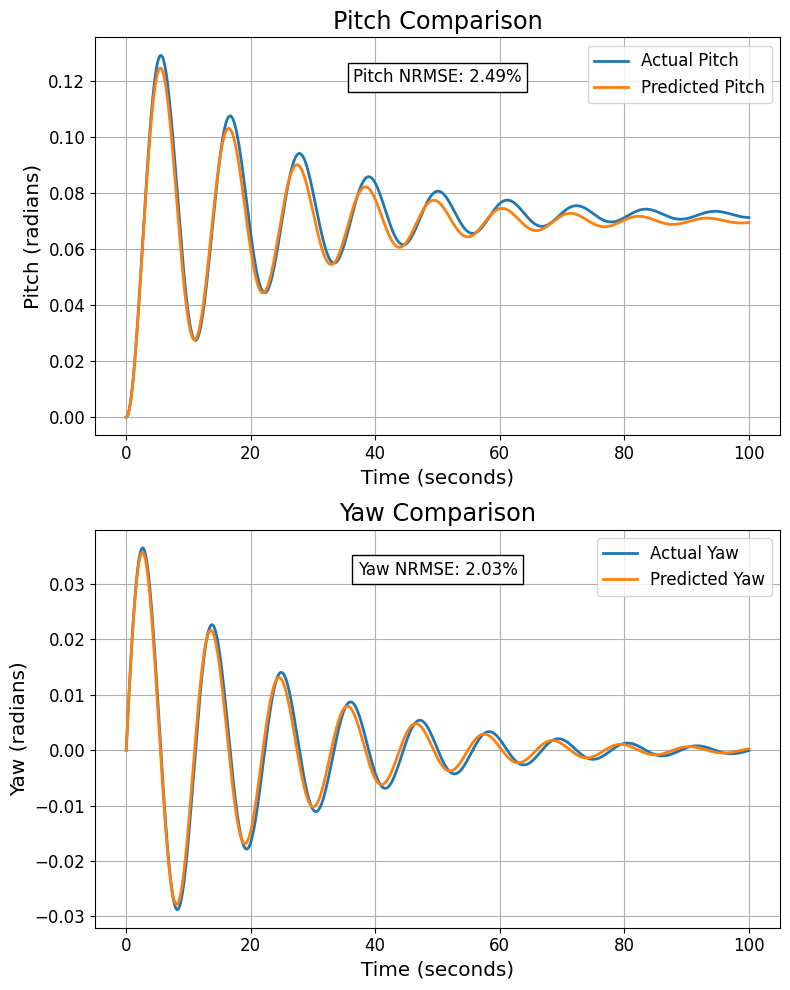

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Define shape and time array
shape = (10000,)
time = np.linspace(0, 100, shape[0])

# Create inputs Vp and Vy
Vp = np.zeros(shape)
Vp[1:] = 1
Vy = np.zeros(shape)
# Vy[1:] = 1

# Combine inputs into a single array
U = np.array([Vp, Vy]).T

# Run simulations using lsim
yout1, T1, xout1 = MATLAB.lsim(AERO1, U, time, 0)
yout2, T2, xout2 = MATLAB.lsim(AERO2, U, time, 0)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))  # Vertical stacking

# Plot actual and predicted pitch
ax1.plot(T1, yout1[:, 0], label='Actual Pitch', linewidth=2)
ax1.plot(T2, yout2[:, 0], label='Predicted Pitch', linewidth=2)
ax1.legend(loc='best', fontsize='large')
ax1.set_xlabel('Time (seconds)', fontsize='x-large')
ax1.set_ylabel('Pitch (radians)', fontsize='x-large')
ax1.set_title('Pitch Comparison', fontsize='xx-large')
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize='large')

# Calculate and display Pitch NRMSE
pitch_nrmse = nrmse(yout1[:, 0], yout2[:, 0])
ax1.text(0.5, 0.9, f'Pitch NRMSE: {pitch_nrmse:.2f}%', ha='center', va='center', fontsize='large', transform=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='black'))

# Plot actual and predicted yaw
ax2.plot(T1, yout1[:, 1], label='Actual Yaw', linewidth=2)
ax2.plot(T2, yout2[:, 1], label='Predicted Yaw', linewidth=2)
ax2.legend(loc='best', fontsize='large')
ax2.set_xlabel('Time (seconds)', fontsize='x-large')
ax2.set_ylabel('Yaw (radians)', fontsize='x-large')
ax2.set_title('Yaw Comparison', fontsize='xx-large')
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize='large')

# Calculate and display Yaw NRMSE
yaw_nrmse = nrmse(yout1[:, 1], yout2[:, 1])
ax2.text(0.5, 0.9, f'Yaw NRMSE: {yaw_nrmse:.2f}%', ha='center', va='center', fontsize='large', transform=ax2.transAxes, bbox=dict(facecolor='white', edgecolor='black'))

plt.tight_layout()
plt.show()
